In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torchvision import datasets, transforms

import zipfile

import shutil
import os
import pandas as pd

device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

In [2]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 2):
        super(AlexNet, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.linear = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.convolutional(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return torch.softmax(x, 1)

In [3]:
model = AlexNet()
model = model.to(device)

In [4]:
'''with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")'''

'with zipfile.ZipFile("celeba.zip","r") as zip_ref:\n  zip_ref.extractall("data_faces/")'

In [5]:

root = '/home/luser/autoencoder_attacks/train_aautoencoders/data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [6]:

df = pd.read_csv("/home/luser/autoencoder_attacks/train_aautoencoders/list_attr_celeba.csv")
df = df[['image_id', 'Young']]

In [7]:
df
#get all the row titles
df.index
# get all the column titles
df.columns

Index(['image_id', 'Young'], dtype='object')

In [8]:
# to make directories

'''!rm -rf data
!mkdir data && mkdir data/male && mkdir data/no_male'''

'!rm -rf data\n!mkdir data && mkdir data/male && mkdir data/no_male'

In [8]:

s0 = 0
s1 = 0

num = 45000

for i, (_, i_row) in enumerate(df.iterrows()):
  if s0 < num:
    if i_row['Young'] == 1:
      s0 += 1
      shutil.copyfile('/home/luser/autoencoder_attacks/train_aautoencoders/data_faces/img_align_celeba/' + i_row['image_id'], 'data_age/young/' + i_row['image_id'])
  
  if s1 < num:
    if i_row['Young'] == -1:
      s1 += 1
      shutil.copyfile('/home/luser/autoencoder_attacks/train_aautoencoders/data_faces/img_align_celeba/' + i_row['image_id'], 'data_age/no_young/' + i_row['image_id'])
  
  if s0 == num and s1 == num:
    break

In [9]:
young_list = os.listdir('data_age/young/')
print(len(young_list))
old_list = os.listdir('data_age/no_young/')
print(len(old_list))

45000
45000


In [10]:

img_list = os.listdir('data_age/young/')
img_list.extend(os.listdir('data_age/no_young/'))

In [11]:
print("Images: ", len(img_list))


Images:  90000


In [12]:

transform = transforms.Compose([
          transforms.Resize((64, 64)),
          transforms.ToTensor()
          ])

batch_size = 64
celeba_data = datasets.ImageFolder('data_age', transform=transform)

In [13]:
print(celeba_data.classes)
print(len(celeba_data))

['no_young', 'young']
90000


In [14]:

train_set, test_set = torch.utils.data.random_split(celeba_data, [int(len(img_list) * 0.75), len(img_list) - int(len(img_list) * 0.75)])
train_data_size = len(train_set)
test_data_size = len(test_set)

In [15]:
trainLoader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True)
testLoader  = torch.utils.data.DataLoader(test_set, batch_size=50650
                                          , shuffle=True)

In [16]:
print(train_data_size)
print(test_data_size)

67500
22500


In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [18]:
epochs = 10
train_loss = []

for epoch in range(epochs):
   
    total_train_loss = 0
    
    # training our model
    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    print(f'Epoch: {epoch} | Train Loss: {total_train_loss}')

In [18]:
#torch.save(model.state_dict(), '/home/luser/robustness_of_subgroups/saved_gender_classifier/age_classifier.torch')

In [19]:
# load the saved model
model = AlexNet().to(device)
model.load_state_dict(torch.load('/home/luser/robustness_of_subgroups/saved_gender_classifier/age_classifier.torch'))

<All keys matched successfully>

In [20]:
plt.plot(train_loss)


NameError: name 'train_loss' is not defined

In [21]:
testiter = iter(testLoader)
images, labels = next(testiter)

with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  pred = model(images)

images_np = [i.cpu() for i in images]
class_names = celeba_data.classes

In [22]:
class_names # 0 indicates male, 1 indicates female

['no_young', 'young']

In [23]:


# Predicted class indices
predictions = np.argmax(pred.cpu().numpy(), 1)

# Actual labels (on CUDA, so we need to move it to CPU and convert to numpy)

labels_np = labels.cpu().numpy()

check = predictions == labels_np

old_indices = np.where(predictions == 0)[0]
young_indices = np.where(predictions == 1)[0]
print(old_indices)
print(check)
# Calculate the number of correct predictions
correct_predictions = np.sum(predictions == labels_np)

print(correct_predictions)

# Calculate accuracy
accuracy = correct_predictions / len(labels)

print(f"Accuracy: {accuracy:.4f}")


[    0     1     3 ... 22497 22498 22499]
[ True  True  True ...  True  True  True]
19707
Accuracy: 0.8759


In [24]:
with torch.no_grad():
  total_correct_predictions = 0
  for images, labels in testLoader:
    images, labels = images.to(device), labels.to(device)
    pred = model(images)

    predictions = np.argmax(pred.cpu().numpy(), 1)
    labels_np = labels.cpu().numpy()
    correct_predictions = np.sum(predictions == labels_np)

    accuracy = correct_predictions / len(labels)

    old_indices = np.where(labels_np == 0)[0]
    young_indices = np.where(labels_np == 1)[0]

    separated_old_labels = labels_np[old_indices]
    separated_young_labels = labels_np[young_indices]

    total_old_labels = len(separated_old_labels)
    total_young_labels = len(separated_young_labels)

    separated_old_predictions = predictions[old_indices]
    separated_young_predictions = predictions[young_indices]

    correct_old_predictions = np.sum(separated_old_labels==separated_old_predictions)
    correct_young_predictions = np.sum(separated_young_labels == separated_young_predictions)



    num_old_labeled_predictions = len(predictions[predictions==0])
    num_young_labeled_predictions = len(predictions[predictions==1])



    num_of_young_wrongly_classified_as_old = num_young_labeled_predictions - correct_young_predictions
    num_of_old_wrongly_classified_as_young = num_old_labeled_predictions - correct_old_predictions





    total_samples = len(labels)
    print()
    print("total_samples", total_samples)
    print()
    print("total_old_labels", total_old_labels)
    print("total_young_labels", total_young_labels)
    print()
    print("correct_predictions", correct_predictions)
    print()
    print(f"Accuracy: {accuracy:.4f}")
    print()
    print("correct_old_predictions", correct_old_predictions)
    print("correct_young_predictions", correct_young_predictions)
    print()
    print("num_old_labeled_predictions", num_old_labeled_predictions)
    print("num_young_labeled_predictions", num_young_labeled_predictions)
    print()
    print("num_of_young_wrongly_classified_as_old", num_of_young_wrongly_classified_as_old)
    print("num_of_old_wrongly_classified_as_young", num_of_old_wrongly_classified_as_young)
    print()
    print("percentage olds misclassified", (num_of_old_wrongly_classified_as_young/total_old_labels)*100)
    print()
    print("percentage youngs misclassified", (num_of_young_wrongly_classified_as_old/total_young_labels)*100)



    break





total_samples 22500

total_old_labels 11181
total_young_labels 11319

correct_predictions 19718

Accuracy: 0.8764

correct_old_predictions 9792
correct_young_predictions 9926

num_old_labeled_predictions 11185
num_young_labeled_predictions 11315

num_of_young_wrongly_classified_as_old 1389
num_of_old_wrongly_classified_as_young 1393

percentage olds misclassified 12.45863518468831

percentage youngs misclassified 12.271402067320434


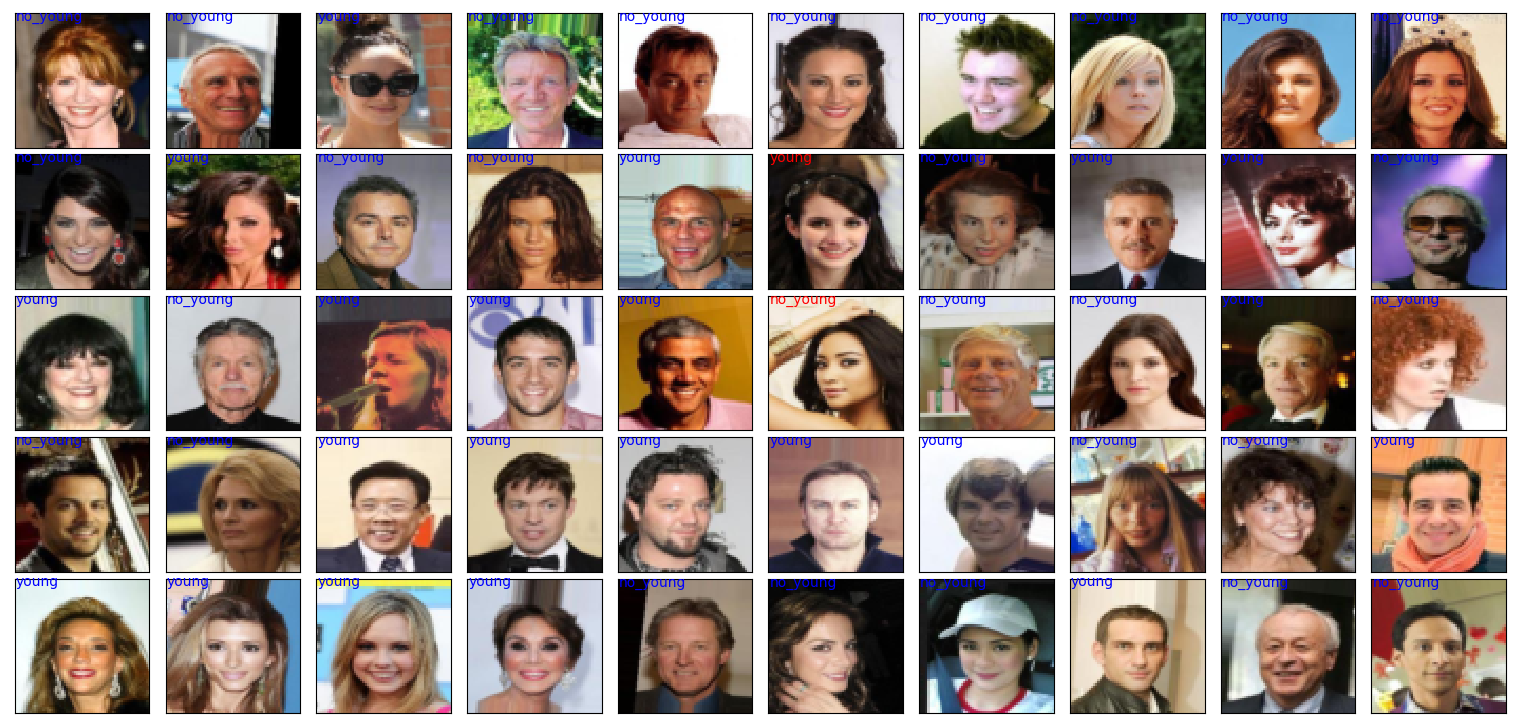

In [25]:

fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i].permute(1, 2, 0), cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[i] == torch.max(pred[i], 0)[1]:
      ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='blue')
    else:
      ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='red')

# Perform the same analysis on attacked samples

In [26]:
#device = ("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

from vae import VAE_big

model_vae = VAE_big(device, image_channels=3).to(device)

train_data_size = 162079
epochs = 199

#beta_value = 5.0


# Attacking Vanilla VAE and beta VAEs


In [163]:
# 0
beta_value = 10.0

if (beta_value == 5.0 or beta_value == 10.0):
    model_vae.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
else:
    model_vae.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))

model_vae.eval()

#segment = 14
prev_div_min = 100.0
prev_div_max = 0.0
all_losses = []

#all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
#all_features = ["youngmen", "youngwomen"]
#all_features = ["youngmen", "oldwomen"]
#all_features = ["oldmen", "youngwomen"]
#all_features = [ "oldmen", "oldwomen"]
#all_features = ["youngmen"]
all_features = ["oldmen"]
#all_features = ["youngwomen"]
#all_features = ["oldwomen"]


#feature = all_features[3]

all_source_images = torch.tensor([]).to(device)
all_div_outputs = torch.tensor([]).to(device)
all_normal_reconstructed_images = torch.tensor([]).to(device)
for feature in all_features:
    for segment in range(60):
        desired_norm_l_inf = 0.094

        #all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

        universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]



        source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
        optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 



        image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
        aspect_ratio = image_width / image_height

        corresponding_class_polulations = [1819, 24707, 145, 2827]
        #inside_feature_name = inside_feature_names[3]



        actualOutput, _, _ = model_vae(source_im)
        ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


        DivAttackeImage = source_im + optimized_noise
        NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
        DivOutput,_,_ = model_vae(NormalDivAttackeImage)
        DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

        all_losses.append(DivOutputL2ActualOutput.item())

        all_source_images = torch.cat((all_source_images, source_im))
        all_normal_reconstructed_images = torch.cat((all_normal_reconstructed_images, actualOutput))
        all_div_outputs = torch.cat((all_div_outputs, DivOutput))
        

if(all_features[0]=="oldwomen" or all_features[0]=="oldmen"):
    adv_samp_labels = torch.zeros(60).to(device)
if(all_features[0]=="youngmen" or all_features[0]=="youngwomen"):
    adv_samp_labels = torch.ones(60).to(device)


In [164]:
adv_samp_labels

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

## Classifier accuracy : inputs are direct images choosen for adversarial experimentation

In [165]:
with torch.no_grad():
  images, labels = all_source_images.to(device), adv_samp_labels.to(device)
  pred = model(images)

  predictions = np.argmax(pred.cpu().numpy(), 1)
  labels_np = labels.cpu().numpy()
  correct_predictions = np.sum(predictions == labels_np)

  accuracy = correct_predictions / len(labels)

  old_indices = np.where(labels_np == 0)[0]
  young_indices = np.where(labels_np == 1)[0]

  separated_old_labels = labels_np[old_indices]
  separated_young_labels = labels_np[young_indices]

  total_old_labels = len(separated_old_labels)
  total_young_labels = len(separated_young_labels)

  separated_old_predictions = predictions[old_indices]
  separated_young_predictions = predictions[young_indices]

  correct_old_predictions = np.sum(separated_old_labels==separated_old_predictions)
  correct_young_predictions = np.sum(separated_young_labels == separated_young_predictions)



  num_old_labeled_predictions = len(predictions[predictions==0])
  num_young_labeled_predictions = len(predictions[predictions==1])



  num_of_young_wrongly_classified_as_old = num_young_labeled_predictions - correct_young_predictions
  num_of_old_wrongly_classified_as_young = num_old_labeled_predictions - correct_old_predictions





  total_samples = len(labels)
  print()
  print("total_samples", total_samples)
  print()
  print("total_old_labels", total_old_labels)
  print("total_young_labels", total_young_labels)
  print()
  print("correct_predictions", correct_predictions)
  print()
  print(f"Accuracy: {accuracy:.4f}")
  print()
  print("correct_old_predictions", correct_old_predictions)
  print("correct_young_predictions", correct_young_predictions)
  print()
  print("num_old_labeled_predictions", num_old_labeled_predictions)
  print("num_young_labeled_predictions", num_young_labeled_predictions)
  print()
  print("num_of_young_wrongly_classified_as_old", num_of_young_wrongly_classified_as_old)
  print("num_of_old_wrongly_classified_as_young", num_of_old_wrongly_classified_as_young)
  print()
  print("percentage olds misclassified", (num_of_old_wrongly_classified_as_young/total_old_labels)*100)
  print()
  print("percentage youngs misclassified", (num_of_young_wrongly_classified_as_old/total_young_labels)*100)




total_samples 60

total_old_labels 60
total_young_labels 0

correct_predictions 60

Accuracy: 1.0000

correct_old_predictions 60
correct_young_predictions 0

num_old_labeled_predictions 60
num_young_labeled_predictions 0

num_of_young_wrongly_classified_as_old 0
num_of_old_wrongly_classified_as_young 0

percentage olds misclassified 0.0

percentage youngs misclassified nan


/tmp/ipykernel_845874/641732512.py:62: RuntimeWarning: invalid value encountered in scalar divide
  print("percentage youngs misclassified", (num_of_young_wrongly_classified_as_old/total_young_labels)*100)


## Classifier accuracy : inputs to classifier are unattacked reconstructions of chosen VAE

In [166]:
with torch.no_grad():
  images, labels = all_normal_reconstructed_images.to(device), adv_samp_labels.to(device)
  pred = model(images)

  predictions = np.argmax(pred.cpu().numpy(), 1)
  labels_np = labels.cpu().numpy()
  correct_predictions = np.sum(predictions == labels_np)

  accuracy = correct_predictions / len(labels)

  old_indices = np.where(labels_np == 0)[0]
  young_indices = np.where(labels_np == 1)[0]

  separated_old_labels = labels_np[old_indices]
  separated_young_labels = labels_np[young_indices]

  total_old_labels = len(separated_old_labels)
  total_young_labels = len(separated_young_labels)

  separated_old_predictions = predictions[old_indices]
  separated_young_predictions = predictions[young_indices]

  correct_old_predictions = np.sum(separated_old_labels==separated_old_predictions)
  correct_young_predictions = np.sum(separated_young_labels == separated_young_predictions)



  num_old_labeled_predictions = len(predictions[predictions==0])
  num_young_labeled_predictions = len(predictions[predictions==1])



  num_of_young_wrongly_classified_as_old = num_young_labeled_predictions - correct_young_predictions
  num_of_old_wrongly_classified_as_young = num_old_labeled_predictions - correct_old_predictions





  total_samples = len(labels)
  print()
  print("total_samples", total_samples)
  print()
  print("total_old_labels", total_old_labels)
  print("total_young_labels", total_young_labels)
  print()
  print("correct_predictions", correct_predictions)
  print()
  print(f"Accuracy: {accuracy:.4f}")
  print()
  print("correct_old_predictions", correct_old_predictions)
  print("correct_young_predictions", correct_young_predictions)
  print()
  print("num_old_labeled_predictions", num_old_labeled_predictions)
  print("num_young_labeled_predictions", num_young_labeled_predictions)
  print()
  print("num_of_young_wrongly_classified_as_old", num_of_young_wrongly_classified_as_old)
  print("num_of_old_wrongly_classified_as_young", num_of_old_wrongly_classified_as_young)
  print()
  print("percentage olds misclassified", (num_of_old_wrongly_classified_as_young/total_old_labels)*100)
  print()
  print("percentage youngs misclassified", (num_of_young_wrongly_classified_as_old/total_young_labels)*100)




total_samples 60

total_old_labels 60
total_young_labels 0

correct_predictions 60

Accuracy: 1.0000

correct_old_predictions 60
correct_young_predictions 0

num_old_labeled_predictions 60
num_young_labeled_predictions 0

num_of_young_wrongly_classified_as_old 0
num_of_old_wrongly_classified_as_young 0

percentage olds misclassified 0.0

percentage youngs misclassified nan


/tmp/ipykernel_845874/1965346055.py:62: RuntimeWarning: invalid value encountered in scalar divide
  print("percentage youngs misclassified", (num_of_young_wrongly_classified_as_old/total_young_labels)*100)


## Classifier accuracy : inputs to classifier are attacked reconstructions of chosen VAE

In [167]:
with torch.no_grad():
  images, labels = all_div_outputs.to(device), adv_samp_labels.to(device)
  pred = model(images)

  predictions = np.argmax(pred.cpu().numpy(), 1)
  labels_np = labels.cpu().numpy()
  correct_predictions = np.sum(predictions == labels_np)

  accuracy = correct_predictions / len(labels)

  old_indices = np.where(labels_np == 0)[0]
  young_indices = np.where(labels_np == 1)[0]

  separated_old_labels = labels_np[old_indices]
  separated_young_labels = labels_np[young_indices]

  total_old_labels = len(separated_old_labels)
  total_young_labels = len(separated_young_labels)

  separated_old_predictions = predictions[old_indices]
  separated_young_predictions = predictions[young_indices]

  correct_old_predictions = np.sum(separated_old_labels==separated_old_predictions)
  correct_young_predictions = np.sum(separated_young_labels == separated_young_predictions)



  num_old_labeled_predictions = len(predictions[predictions==0])
  num_young_labeled_predictions = len(predictions[predictions==1])



  num_of_young_wrongly_classified_as_old = num_young_labeled_predictions - correct_young_predictions
  num_of_old_wrongly_classified_as_young = num_old_labeled_predictions - correct_old_predictions





  total_samples = len(labels)
  print()
  print("total_samples", total_samples)
  print()
  print("total_old_labels", total_old_labels)
  print("total_young_labels", total_young_labels)
  print()
  print("correct_predictions", correct_predictions)
  print()
  print(f"Accuracy: {accuracy:.4f}")
  print()
  print("correct_old_predictions", correct_old_predictions)
  print("correct_young_predictions", correct_young_predictions)
  print()
  print("num_old_labeled_predictions", num_old_labeled_predictions)
  print("num_young_labeled_predictions", num_young_labeled_predictions)
  print()
  print("num_of_young_wrongly_classified_as_old", num_of_young_wrongly_classified_as_old)
  print("num_of_old_wrongly_classified_as_young", num_of_old_wrongly_classified_as_young)
  print()
  print("percentage olds misclassified", (num_of_old_wrongly_classified_as_young/total_old_labels)*100)
  print()
  print("percentage youngs misclassified", (num_of_young_wrongly_classified_as_old/total_young_labels)*100)




total_samples 60

total_old_labels 60
total_young_labels 0

correct_predictions 58

Accuracy: 0.9667

correct_old_predictions 58
correct_young_predictions 0

num_old_labeled_predictions 58
num_young_labeled_predictions 2

num_of_young_wrongly_classified_as_old 2
num_of_old_wrongly_classified_as_young 0

percentage olds misclassified 0.0

percentage youngs misclassified inf


/tmp/ipykernel_845874/834668152.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  print("percentage youngs misclassified", (num_of_young_wrongly_classified_as_old/total_young_labels)*100)
